# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.078621,True,5.757184
1,-0.400388,False,0.342392
2,0.709590,False,-0.711664
3,1.271127,True,7.712637
4,0.663324,True,6.137904
...,...,...,...
995,0.492527,True,4.721456
996,-0.756521,True,5.777454
997,0.860135,True,5.754291
998,2.396059,True,7.328236


<Axes: xlabel='v0'>

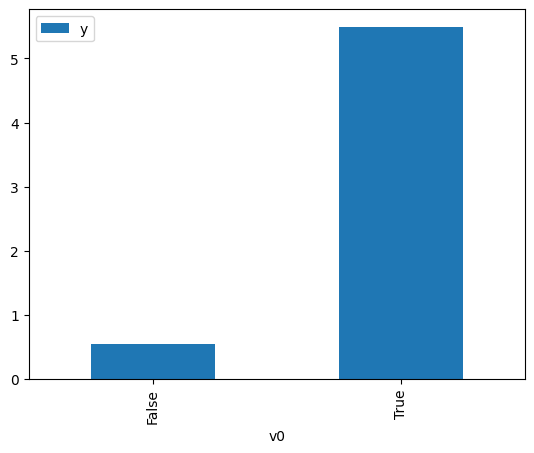

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

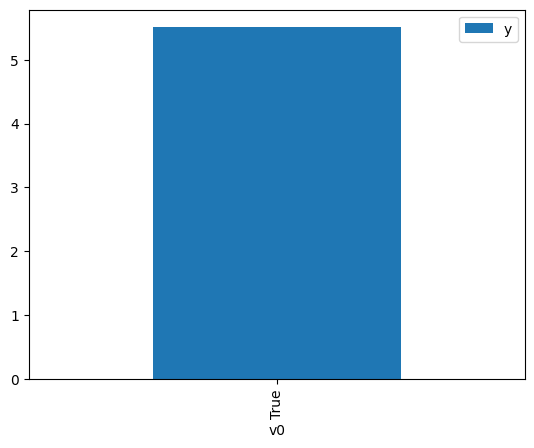

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.561784,False,1.699687,0.640206,1.561998
1,1.405092,False,1.487388,0.236992,4.219545
2,1.248757,False,0.406419,0.262987,3.802469
3,0.749027,False,0.388386,0.357320,2.798616
4,2.955526,False,3.551139,0.072752,13.745346
...,...,...,...,...,...
995,0.637684,False,-1.221019,0.380316,2.629391
996,1.436533,False,0.936511,0.231984,4.310640
997,0.322269,False,0.470925,0.448114,2.231573
998,2.305079,False,2.052642,0.122611,8.155844


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.816677,True,3.852852,0.309499,3.231023
1,1.968859,True,6.538102,0.841516,1.188331
2,-0.184577,True,5.077278,0.439915,2.273164
3,2.360386,True,5.509986,0.882572,1.133053
4,1.160772,True,6.447363,0.721601,1.385807
...,...,...,...,...,...
995,0.319286,True,3.996884,0.551231,1.814122
996,0.132959,True,5.847473,0.510071,1.960510
997,-0.382184,True,5.544882,0.397266,2.517206
998,1.660791,True,4.400576,0.801574,1.247546


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              9289.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):                        0.00
Time:                        15:40:46   Log-Likelihood:                         -1453.5
No. Observations:                1000   AIC:                                      2911.
Df Residuals:                     998   BIC:                                      2921.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7329      0.036     20.363      0.000       0.662       0.804
x2             5.0427      0.053     94.423      0.000       4.938       5.148
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                1.264
Skew:                          -0.036   Prob(JB):                        0.532
Kurtosis:                       2.842   Cond. No.                         2.28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""